# Notebook for the Regression Model - Mobility Per Person
## Last Updated: 10-06-2020

In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data

In [2]:
collect_datasets = collect_data.DataCollection()

In [3]:
df_mobility = collect_datasets.get_mobility_data()
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

In [4]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics,covid=False):
    df_mob = df_mob.dropna()
    covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
    if covid:
        df_mob_covid = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_covid = df_mob_covid[df_mob_covid.date >covid_date]
    else:
        df_mob_covid = df_mob[df_mob.date < covid_date]
        
    df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['State Postal Code', 'Level']), 
                      right = df_demographics, on = ['fips'])
    df_all['party'] =df_all['party'].fillna('republican')
    return df_all

In [5]:
def run_model(df,name,target_var,remove_col_list,task_type='GPU',max_depth= 6):
    
    remove_cols = ['date','fips','COUNTY','YEAR','NAME_E' ] + remove_col_list
    
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=[target_var])
    y =df_final[[target_var]]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth,devices='0',learning_rate=0.35,
                                          verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 15.6189526	total: 618ms	remaining: 10m 17s
200:	learn: 9.0427149	total: 1m 38s	remaining: 6m 32s
400:	learn: 8.4282630	total: 3m 14s	remaining: 4m 50s
600:	learn: 8.0699294	total: 4m 46s	remaining: 3m 9s
800:	learn: 7.7992971	total: 6m 19s	remaining: 1m 34s
999:	learn: 7.5628254	total: 7m 55s	remaining: 0us
0.72


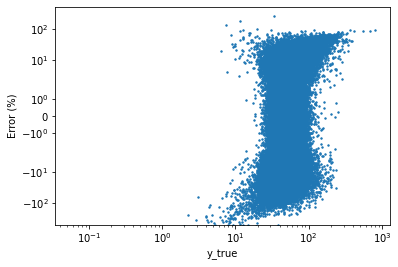

,Pre_Covid_Feature_Importance
STATE,9.564681
sunHour,5.654437
Median Household Income in the Past 12 Months (in 2018 Inflation-Adjusted Dollars)_Median household income in the past 12 months (in 2018 inflation-adjusted dollars),4.055100
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,2.474889
pct_republican,1.957843
HeatIndexC,1.754880
Travel Time to Work_60 to 89 minutes,1.753129
Race_Black or African American alone,1.743298
Sex by Age_Female 25 to 29 years,1.730731
AKGVE001,1.658905


In [6]:
target_var = 'mobility_per_person'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_pre = get_model_df(df_weather, df_mobility,df_covid,df_county)
remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_pre and col not in keep_cols]

df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,'Pre', target_var,remove_col_list,task_type='CPU',max_depth = 8)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

Total Rows Test Dataset 271708 ||| Records with over 200% error 134


,error_pct,Count
STATE,,
Connecticut,-3.859432,744
Alaska,-3.276756,2113
Montana,-2.576011,4290
North Dakota,-2.143900,4249
Idaho,-1.469335,3699
Vermont,-1.308497,1217
Maine,-1.233425,1347
New Hampshire,-1.177587,876
Nebraska,-1.091702,7416


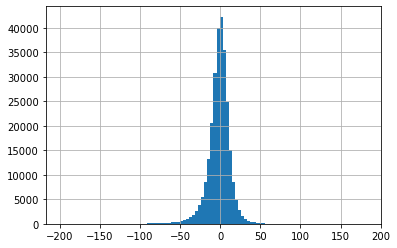

In [7]:
pd.options.mode.chained_assignment = None
y_test['pred']= y_pred_cb
y_test['error_pct'] = (y_test[target_var] - y_test.pred)*100/y_test[target_var]
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')

0:	learn: 17.1350935	total: 232ms	remaining: 3m 52s
200:	learn: 8.3031128	total: 45.8s	remaining: 3m 1s
400:	learn: 7.3514993	total: 1m 32s	remaining: 2m 17s
600:	learn: 6.7730877	total: 2m 18s	remaining: 1m 32s
800:	learn: 6.3221426	total: 3m 5s	remaining: 46.1s
999:	learn: 5.9512884	total: 3m 51s	remaining: 0us
0.77


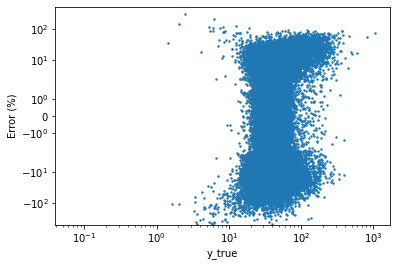

,Post_Covid_Feature_Importance
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,4.704452
case_rate,4.650711
Means of Transportation to Work_Total,4.306976
Public Assistance Income or Food Stamps/SNAP in the Past 12 Months for Households_Total,4.272112
STATE,4.209018
Travel Time to Work_Total,3.698241
WindChillC,2.285505
sunHour,2.070480
Sex by Age_Female 62 to 64 years,1.987529
pressure,1.718049


In [11]:
df_mob_train_covid = get_model_df(df_weather, df_mobility,df_covid,df_county,covid=True)
remove_col_list_COVID = [col for col in df_mobility.columns if col in df_mob_train_covid and col not in keep_cols]
remove_col_list_COVID.extend(['Lat','Lng'])
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_covid,'Post', target_var,remove_col_list_COVID,task_type='CPU',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

Total Rows Test Dataset 111255 ||| Records with over 200% error 115


,error_pct,Count
STATE,,
Alaska,-5.210352,934
Vermont,-2.900135,466
Hawaii,-2.846329,146
Montana,-1.717590,1962
Massachusetts,-1.525267,496
Idaho,-1.475747,1542
Nevada,-1.345195,584
Rhode Island,-1.269828,167
Maryland,-1.251349,829


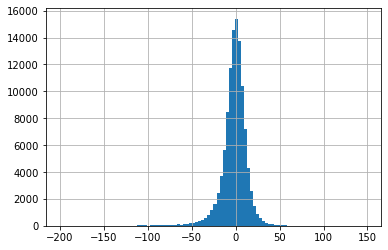

In [12]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test[target_var] - y_test.pred)*100/y_test[target_var]
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')